<a href="https://colab.research.google.com/github/shalabh147/Brain-Tumor-Segmentation-and-Survival-Prediction-using-Deep-Neural-Networks/blob/master/surv_pred_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
import tensorflow as tf
import keras.backend as K
# import keras
# from ensorflow import keras
from keras import layers
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,Maximum,Flatten
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
# from tensorflow.keras.layers.convolutional import Conv2D, Conv2DTranspose,Conv3D,Conv3DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D,MaxPooling3D,AveragePooling2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from sklearn.utils import class_weight
from keras.models import Sequential
import nibabel as nib

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
path1 = '../input/vs-brats2018/miccai_brats_2018_data_training/survival_data.csv'
#print(os.listdir(path))
# Brats18_CBICA_ANP_1
# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import csv
#import pickle

#from joblib import dump

age_dict = {}
days_dict = {}




with open(path1, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file,delimiter = ',')
    line_count = 0
    a = 0
    b = 0
    c = 0
    for row in csv_reader:
        if line_count == 0:
            print(f'Column names are {", ".join(row)}')
            line_count += 1
        else:
            print(row)
            key = row[0]
            age = row[1]
            days = row[2]
            age_dict[key] = float(age)
            days_dict[key] = int(days)
            if int(days) < 250:
                a += 1
            elif (int(days) >= 250 and int(days) <= 500):
                b += 1
            else:
                c += 1
            line_count+=1

    print(f'Processed {line_count} lines.')
    #age_m = np.zeros((1,1))
    print(a,b,c)

Column names are BraTS18ID, Age, Survival, ResectionStatus
['Brats18_TCIA08_167_1', '74.907', '153', 'NA']
['Brats18_TCIA08_242_1', '66.479', '147', 'NA']
['Brats18_TCIA08_319_1', '64.86', '254', 'NA']
['Brats18_TCIA08_469_1', '63.899', '519', 'NA']
['Brats18_TCIA08_218_1', '57.345', '346', 'NA']
['Brats18_TCIA08_406_1', '78.745', '82', 'NA']
['Brats18_TCIA08_280_1', '57.362', '508', 'NA']
['Brats18_TCIA08_105_1', '66.627', '77', 'NA']
['Brats18_TCIA08_278_1', '50.501', '1458', 'NA']
['Brats18_TCIA06_247_1', '76.699', '244', 'NA']
['Brats18_TCIA06_372_1', '74.521', '213', 'NA']
['Brats18_TCIA06_165_1', '51.756', '5', 'NA']
['Brats18_TCIA06_409_1', '69.266', '99', 'NA']
['Brats18_TCIA06_184_1', '61.167', '434', 'NA']
['Brats18_TCIA05_277_1', '70.367', '232', 'NA']
['Brats18_TCIA05_478_1', '59.255', '30', 'NA']
['Brats18_TCIA04_437_1', '46.953', '333', 'NA']
['Brats18_TCIA04_361_1', '75.973', '476', 'NA']
['Brats18_TCIA04_192_1', '75.962', '121', 'NA']
['Brats18_TCIA04_479_1', '56.4', '3

In [ ]:
def SurvPredNet(input_img,age_m):
    #input_img = BatchNormalization()(input_img)
    a1 = Conv2D(16,kernel_size = (3,3) , padding='same')(input_img)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(24,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = MaxPooling2D(pool_size = (2,2) , strides = (2,2))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding='same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = AveragePooling2D(pool_size = (6,6) , strides = (1,1))(a1)
    
    a1 = Conv2D(32,kernel_size = (3,3) , padding = 'same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = AveragePooling2D(pool_size = (5,5) , strides = (1,1))(a1)
    a1 = Conv2D(32,kernel_size = (3,3) , padding = 'same')(a1)
    a1 = BatchNormalization()(a1)
    a1 = Activation('relu')(a1)
    
    a1 = AveragePooling2D(pool_size = (6,6) , strides = (1,1))(a1)
    
    a1 = Flatten()(a1)
    a1 = concatenate([a1,age_m])
    a1 = BatchNormalization()(a1)
    
    a1 = Dense(32,activation = 'relu')(a1)
    a1 = Dense(16,activation = 'relu')(a1)
    outputs = Dense(3,activation = 'softmax')(a1)
    
    model = Model(inputs = [input_img,age_m] , outputs = outputs)
    
    return model
    
    
    
    

In [ ]:
input_img = Input((240,240,5))
age_m = Input((1))
model = SurvPredNet(input_img,age_m)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 240, 240, 5) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 240, 240, 16) 736         input_9[0][0]                    
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 240, 240, 16) 64          conv2d_28[0][0]                  
__________________________________________________________________________________________________
activation_28 (Activation)      (None, 240, 240, 16) 0           batch_normalization_32[0][0]     
____________________________________________________________________________________________

In [ ]:
path = '../input/vs-brats2018/miccai_brats_2018_data_training/HGG'
all_images = os.listdir(path)
#print(len(all_images))
all_images.sort()

def standardize(image):

  standardized_image = np.zeros(image.shape)

  #
 
      # iterate over the `z` dimension
  for z in range(image.shape[2]):
      # get a slice of the image
      # at channel c and z-th dimension `z`
      image_slice = image[:,:,z]

      # subtract the mean from image_slice
      centered = image_slice - np.mean(image_slice)
     
      # divide by the standard deviation (only if it is different from zero)
      if(np.std(centered)!=0):
          centered = centered/np.std(centered)

      # update  the slice of standardized image
      # with the scaled centered and scaled image
      standardized_image[:, :, z] = centered

  ### END CODE HERE ###

  return standardized_image


In [ ]:
cnt = 0
for image_num in range(170):
    image1 = all_images[image_num]
    if image1 in days_dict:
        cnt += 1
        
print(cnt)

134


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:42: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:37: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0


Epoch 1/80
3/3 [==============================] - 0s 41ms/step - loss: 1.2000 - accuracy: 0.3731
Epoch 2/80
3/3 [==============================] - 0s 32ms/step - loss: 1.0116 - accuracy: 0.5224
Epoch 3/80
3/3 [==============================] - 0s 33ms/step - loss: 1.0090 - accuracy: 0.5597
Epoch 4/80
3/3 [==============================] - 0s 35ms/step - loss: 0.9584 - accuracy: 0.5896
Epoch 5/80
3/3 [==============================] - 0s 46ms/step - loss: 0.9533 - accuracy: 0.5970
Epoch 6/80
3/3 [==============================] - 0s 39ms/step - loss: 0.9136 - accuracy: 0.5522
Epoch 7/80
3/3 [==============================] - 0s 35ms/step - loss: 0.8822 - accuracy: 0.6269
Epoch 8/80
3/3 [==============================] - 0s 30ms/step - loss: 0.8661 - accuracy: 0.6194
Epoch 9/80
3/3 [==============================] - 0s 27ms/step - loss: 0.8380 - accuracy: 0.6119
Epoch 10/80
3/3 [==============================] - 0s 28ms/step - loss: 0.8205 - accuracy: 0.6269
Epoch 11/80
3/3 [============

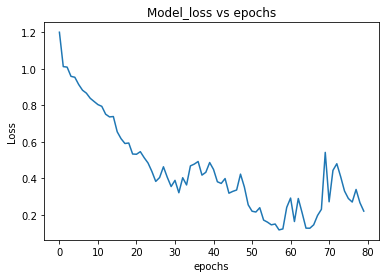

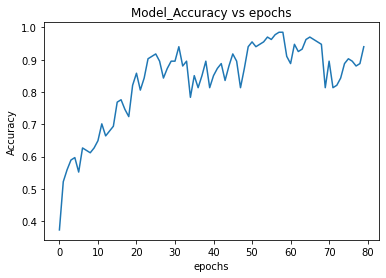

"\nplt.plot(accu_hist)\nplt.title('model accuracy')\nplt.ylabel('accuracy')\nplt.xlabel('epoch')\ns = '../working/accuracy_plot_' + str(epochs)\nplt.savefig(s)\nplt.show()\nplt.close()\n\nplt.plot(loss_hist)\nplt.title('model loss')\nplt.ylabel('loss')\nplt.xlabel('epoch')\ns = '../working/loss_plot_' + str(epochs)\nplt.savefig(s)\nplt.show()\nplt.close()\n\nmodel.save('../working/2d_4class_axis1.h5')\n"

In [ ]:
loss_hist = []
accu_hist = []
epoch_wise_loss = []
epoch_wise_accu = []
#for epochs in range(45):
epoch_loss = 0
epoch_accu = 0
input_to_model = np.zeros((134,240,240,5))
age = np.zeros((134,1))
ground_truth = np.zeros((134,3))
cnt = 0
for image_num in range(170):
    #print(epochs)
    #print("image_num ",image_num)
    #print("cnt" ,cnt)
    data = np.zeros((240,240,155,4))
    image_data2=np.zeros((240,240,155))

    # data preprocessing starts here

    x = all_images[image_num]
    
    if x in days_dict:
        #print(cnt)
        #print(x)
        folder_path = path + '/' + x;
        modalities = os.listdir(folder_path)
        modalities.sort()
        #data = []
        w = 0
        for j in range(len(modalities)):
          #print(modalities[j])

          image_path = folder_path + '/' + modalities[j]
          if not(image_path.find('seg.nii') == -1):
            img = nib.load(image_path);
            image_data2 = img.get_data()
            image_data2 = np.asarray(image_data2)
            #print("Entered ground truth")
          else:
            img = nib.load(image_path);
            image_data = img.get_data()
            image_data = np.asarray(image_data)
            image_data = standardize(image_data)
            data[:,:,:,w] = image_data
            #print("Entered modality")
            w = w+1

        #print(data.shape)
        #print(image_data2.shape)
        image_data2[image_data2 == 4] = 3

        input_to_model[cnt,:,:,:4] = data[:,:,75,:]
        input_to_model[cnt,:,:,4] = image_data2[:,:,75]
        #age = np.zeros((1,1))
        age[cnt,0] = float(age_dict[x])
        days = int(days_dict[x])
        

        #ground_truth = np.zeros((1,3))
        #print(age[cnt,0])

        if int(days) < 300:
            ground_truth[cnt,0] = 1
        elif (int(days) >= 300 and int(days) <= 450):
            ground_truth[cnt,1] = 1
        else:
            ground_truth[cnt,2] = 1 
        
        #print(ground_truth[cnt])
        cnt += 1
        

    #y_to = keras.utils.to_categorical(y_to,num_classes=4)
history = model.fit(x=[input_to_model,age],y=ground_truth, epochs = 80 , batch_size = 64)
print(history.history['loss'])
#epoch_loss += history.history['loss'][0]
#epoch_accu += history.history['accuracy'][0]

#loss_hist.append(history.history['loss'])
#accu_hist.append(history.history['accuracy'])

model.save('../working/surv_pred3.h5')
#epoch_loss = epoch_loss/180
#epoch_accu = epoch_accu/180

#epoch_wise_loss.append(epoch_loss)
#epoch_wise_accu.append(epoch_accu)
 
plt.plot(history.history['loss'])
plt.title('Model_loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('epochs')
s = '../working/epochwise_loss'
plt.savefig(s)
plt.show()
plt.close()

plt.plot(history.history['accuracy'])
plt.title('Model_Accuracy vs epochs')
plt.ylabel('Accuracy')
plt.xlabel('epochs')
s = '../working/epochwise_accuracy'
plt.savefig(s)
plt.show()
plt.close()

'''
plt.plot(accu_hist)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
s = '../working/accuracy_plot_' + str(epochs)
plt.savefig(s)
plt.show()
plt.close()

plt.plot(loss_hist)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
s = '../working/loss_plot_' + str(epochs)
plt.savefig(s)
plt.show()
plt.close()

model.save('../working/2d_4class_axis1.h5')
'''